# Imports

In [63]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [64]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.8f}'.format)

# Reading the data

In [66]:
df = pd.read_csv('filtered_normalized_csv.csv')

In [67]:
df.head()

,act_data_pkt_fwd,init_win_bytes_forward,totallengthoffwdpackets,avgbwdsegmentsize,destinationport,bwdiattotal,fwdpacketlengthstd,init_win_bytes_backward,totallengthofbwdpackets,bwdpacketlengthmin,fwdiatmin,fwdpacketlengthmin,bwdpackets/s,maxpacketlength,urgflagcount,bwdiatmean,minpacketlength,bwdiatstd,down/upratio,flowiatmin,min_seg_size_forward,flowpackets/s,flowbytes/s,flowiatmean,finflagcount,pshflagcount,idlemin,idlemax,label
0,-0.18840810,-0.52435981,-0.28544964,-0.79498298,2.32829593,-0.29863037,-0.26952947,-0.13938317,-0.15199379,-0.33162875,-0.05464309,-0.13399270,-0.08252042,-0.84456960,-0.40476006,-0.20663573,-0.13147696,-0.29410281,-0.70303302,-0.03700626,-0.35579937,5.66813993,0.20222141,-0.58511623,-0.05154070,-0.73575929,-0.39110528,-0.47840805,0
1,-0.26990196,-0.52485745,-0.28729601,-0.78962776,2.33786459,-0.29863037,-0.26952947,-0.07986306,-0.15184081,-0.21258792,-0.05464388,-0.13399270,0.37856102,-0.84456960,2.47059948,-0.20663573,-0.13147696,-0.29410281,-0.00414605,-0.03686677,-0.35579937,0.03568444,-0.02814857,-0.58507699,-0.05154070,-0.73575929,-0.39110528,-0.47840805,0
2,-0.26990196,-0.52485745,-0.28729601,-0.78962776,2.33791522,-0.29863037,-0.26952947,-0.07986306,-0.15184081,-0.21258792,-0.05464388,-0.13399270,0.88397725,-0.84456960,2.47059948,-0.20663573,-0.13147696,-0.29410281,-0.00414605,-0.03694178,-0.35579937,0.21042137,-0.02100175,-0.58509809,-0.05154070,-0.73575929,-0.39110528,-0.47840805,0
3,-0.26990196,-0.52460863,-0.28729601,-0.78962776,1.89142823,-0.29863037,-0.26952947,-0.06295657,-0.15184081,-0.21258792,-0.05464388,-0.13399270,1.39565250,-0.84456960,2.47059948,-0.20663573,-0.13147696,-0.29410281,-0.00414605,-0.03696547,-0.35579937,0.38732220,-0.01376642,-0.58510475,-0.05154070,-0.73575929,-0.39110528,-0.47840805,0
4,-0.18840810,-0.52448422,-0.28544964,-0.79498298,2.32819467,-0.29863037,-0.26952947,-0.13938317,-0.15199379,-0.33162875,-0.05464309,-0.13399270,-0.08252042,-0.84456960,-0.40476006,-0.20663573,-0.13147696,-0.29410281,-0.70303302,-0.03700626,-0.35579937,5.66813993,0.20222141,-0.58511623,-0.05154070,-0.73575929,-0.39110528,-0.47840805,0


In [68]:
df.label.value_counts()

1    128025
0     97686
Name: label, dtype: int64

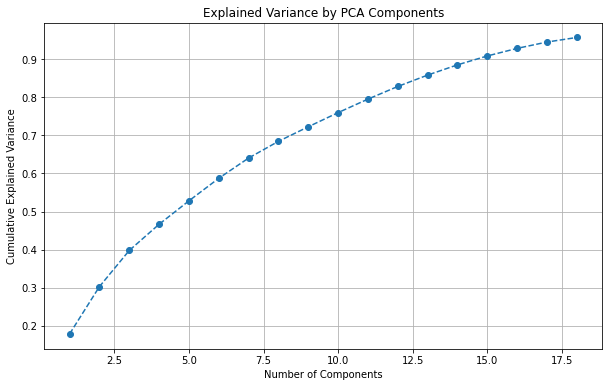

In [69]:
# Split the data into features and labels
X = df.drop(['label'], axis=1)
y = df['label']

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of the variance
X_pca = pca.fit_transform(X)

# Plot the explained variance by each component
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Modeling ML solution and results

In [71]:
# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\romanrosh\anaconda3\envs\tensorflow\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\romanrosh\anaconda3\envs\tensorflow\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Number of positive: 128025, number of negative: 97686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 225711, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

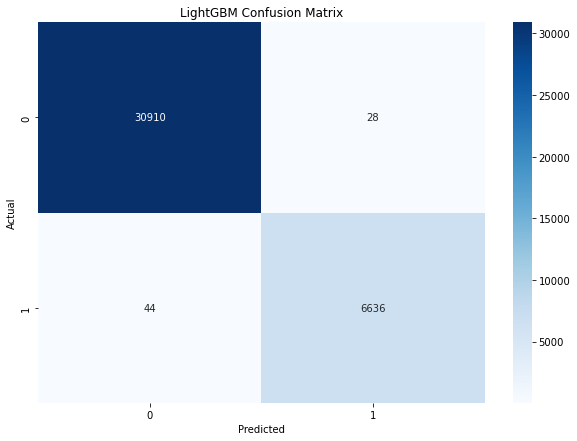

In [72]:
# Define parameter grid for GridSearch
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 50, None],
    'learning_rate': [0.1, 0.01, 0.05],
    'class_weight': ['balanced']
}

# Initialize LightGBM model
lgbm = LGBMClassifier(random_state=42)

# Perform GridSearchCV for LightGBM on PCA-transformed data
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, cv=tscv, n_jobs=-1, verbose=3)
grid_search_lgbm.fit(X_pca, y)
best_lgbm = grid_search_lgbm.best_estimator_

# Evaluate the models on the last fold (as a simulation of future data)
train_index, test_index = list(tscv.split(X_pca))[-1]
X_train_pca, X_test_pca = X_pca[train_index], X_pca[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Refit the best model on the training set
best_lgbm.fit(X_train_pca, y_train)

# Predict using the refitted model
y_pred_lgbm = best_lgbm.predict(X_test_pca)

# Print evaluation metrics
print("LightGBM Classifier:")
print(classification_report(y_test, y_pred_lgbm))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred_lgbm))

# Confusion Matrix for LightGBM
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues')
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Epoch 1/5
4703/4703 [==============================] - 18s 4ms/step - loss: 0.0116 - accuracy: 0.9973 - val_loss: 0.0027 - val_accuracy: 0.9992
Epoch 2/5
4703/4703 [==============================] - 17s 4ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0015 - val_accuracy: 0.9997
Epoch 3/5
4703/4703 [==============================] - 17s 4ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 4/5
4703/4703 [==============================] - 17s 4ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 5/5
1176/1176 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30938
           1       0.99      0.99      0.99      6680

    accuracy                           1.00     37618
   macro avg       1.00      1.00      1.00     37618
weighted avg       1.00      1.00      1.00     37618

NN Classifier:
              p

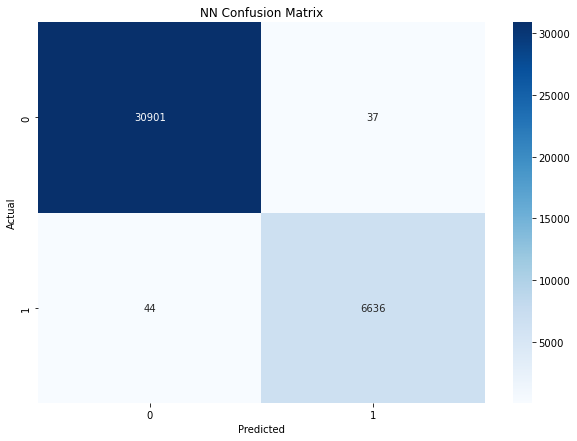

In [73]:
# Evaluate the models on the last fold (as a simulation of future data)
train_index, test_index = list(tscv.split(X))[-1]
X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
y_train, y_test = y[train_index], y[test_index]

# Build the model
model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Print evaluation metrics
print("NN Classifier:")
print(classification_report(y_test, y_pred))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))

# Confusion Matrix for NN
cm_nn = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.title('NN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()